In [1]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id').sample(500_000)
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

In [4]:
train.head(10).T

id,872860,623252,924497,1051120,827511,780792,453926,751685,606388,991854
MonsoonIntensity,6.00,2.00,5.0,4.000,0.00,6.00,3.000,4.000,7.000,8.000
TopographyDrainage,5.00,4.00,8.0,2.000,2.00,8.00,4.000,2.000,4.000,6.000
RiverManagement,4.00,8.00,4.0,6.000,9.00,4.00,7.000,4.000,3.000,4.000
Deforestation,7.00,7.00,5.0,4.000,5.00,5.00,5.000,2.000,4.000,6.000
Urbanization,4.00,4.00,5.0,5.000,2.00,5.00,5.000,2.000,6.000,4.000
ClimateChange,3.00,2.00,3.0,3.000,4.00,3.00,4.000,4.000,4.000,7.000
DamsQuality,3.00,3.00,6.0,9.000,5.00,6.00,4.000,4.000,5.000,5.000
Siltation,5.00,8.00,9.0,4.000,3.00,5.00,5.000,3.000,3.000,5.000
AgriculturalPractices,3.00,2.00,5.0,4.000,9.00,4.00,4.000,4.000,5.000,5.000
Encroachments,4.00,10.00,4.0,4.000,5.00,5.00,8.000,3.000,4.000,5.000


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,500000.0,4.920424,2.058291,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,500000.0,4.927526,2.093271,0.000,3.00,5.000,6.00,17.000
RiverManagement,500000.0,4.955554,2.071886,0.000,4.00,5.000,6.00,16.000
Deforestation,500000.0,4.944848,2.052342,0.000,4.00,5.000,6.00,17.000
Urbanization,500000.0,4.940850,2.082189,0.000,3.00,5.000,6.00,17.000
ClimateChange,500000.0,4.933670,2.059811,0.000,3.00,5.000,6.00,16.000
DamsQuality,500000.0,4.952488,2.083204,0.000,4.00,5.000,6.00,16.000
Siltation,500000.0,4.923166,2.062421,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,500000.0,4.944804,2.070426,0.000,3.00,5.000,6.00,16.000
Encroachments,500000.0,4.951852,2.082395,0.000,4.00,5.000,6.00,18.000


# Preprocessing
- Using sum feature suggested by @ambrosm [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274)
- Sorting features as suggested by @siukeitin [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579)
- Adding a few other statistical features which have been suggested on the forums by various people

In [6]:
def add_stat_features(dataframe, cols, unique_vals):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe["_sum_log"] = np.log1p(dataframe["_sum"])
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_median'] = dataframe[cols].median(1)
    dataframe['_max'] = dataframe[cols].max(1)
    dataframe['_min'] = dataframe[cols].min(1)
    dataframe['_var'] = dataframe[cols].var(1)
    dataframe['_std'] = dataframe[cols].std(1)
    dataframe['_mode'] = dataframe[cols].mode(1)[0]
    dataframe['_skew'] = dataframe[cols].skew(axis=1)
    dataframe['_kurtosis'] = dataframe[cols].kurtosis(axis=1)
    dataframe['_25th'] = dataframe[cols].quantile(0.25, axis=1)
    dataframe['_75th'] = dataframe[cols].quantile(0.75, axis=1)
    dataframe['_hmean'] = len(cols) / dataframe[cols].apply(lambda x: (1/x).mean(), axis=1)
    dataframe['_gmean'] = dataframe[cols].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    dataframe['_2nd_moment'] = dataframe[cols].apply(lambda x: (x**2).mean(), axis=1)
    dataframe['_3rd_moment'] = dataframe[cols].apply(lambda x: (x**3).mean(), axis=1)
    dataframe['_entropy'] = dataframe[cols].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    dataframe['_special1'] = dataframe['_sum'].isin(np.arange(72, 76))
    
    sorted_features = [f"_sort_{i}" for i in np.arange(len(cols))]
    dataframe[sorted_features] = np.sort(dataframe[cols], axis=1)
    
    for i in range(10, 100, 10):
        dataframe[f'_{i}th'] = dataframe[cols].quantile(i/100, axis=1)

    for v in unique_vals:
        dataframe['_cnt{}'.format(v)] = (dataframe[cols] == v).sum(axis=1)

    return dataframe

In [7]:
feature_cols = list(test.columns)
target_col = 'FloodProbability'

unique_vals = []
for df in [train, test]:
    for col in feature_cols:
        unique_vals += list(df[col].unique())
unique_vals = list(set(unique_vals))

**I will be running three different experiments with three variations of the dataset. These datasets will be used to train a predefined set of regressors.**

1. Using the original dataset to train the models
2. Adding statistical features and removing the original features before training
3. Using both original and added statistical features for training

In [8]:
# Original data
train_0 = train.copy()

# Data with statistical features
train_1 = train.copy()
train_1 = add_stat_features(train_1, feature_cols, unique_vals)
train_1 = train_1.drop(feature_cols, axis=1)

# Data with original and statistical features
train_2 = train.copy()
train_2 = add_stat_features(train_2, feature_cols, unique_vals)

del train

In [9]:
X_0 = train_0.drop(target_col, axis=1)
y_0 = train_0[target_col]

X_1 = train_1.drop(target_col, axis=1)
y_1 = train_1[target_col]

X_2 = train_2.drop(target_col, axis=1)
y_2 = train_2[target_col]

del train_0, train_1, train_2

# Training Models

In [10]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [11]:
models = [
    CatBoostRegressor(random_state=SEED, verbose=False),
    LGBMRegressor(random_state=SEED, verbose=-1),
    GradientBoostingRegressor(random_state=SEED),
    XGBRegressor(random_state=SEED, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED, n_jobs=-1)
]

In [12]:
model_scores_0 = {}
model_preds_0 = {}
for model in models:
    scores, preds = Trainer(model, X_0, y_0, N_SPLITS, N_REPEATS).fit()
    model_scores_0[model.__class__.__name__] = scores
    model_preds_0[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.84584 ± 0.00170
LGBMRegressor: 0.76466 ± 0.00114
GradientBoostingRegressor: 0.61391 ± 0.00065
XGBRegressor: 0.80411 ± 0.00225
HistGradientBoostingRegressor: 0.76506 ± 0.00092
ExtraTreesRegressor: 0.64775 ± 0.00073


In [13]:
model_scores_1 = {}
model_preds_1 = {}
for model in models:
    scores, preds = Trainer(model, X_1, y_1, N_SPLITS, N_REPEATS).fit()
    model_scores_1[model.__class__.__name__] = scores
    model_preds_1[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.86886 ± 0.00136
LGBMRegressor: 0.86870 ± 0.00133
GradientBoostingRegressor: 0.86717 ± 0.00128
XGBRegressor: 0.86835 ± 0.00133
HistGradientBoostingRegressor: 0.86859 ± 0.00132
ExtraTreesRegressor: 0.83254 ± 0.00166


In [14]:
model_scores_2 = {}
model_preds_2 = {}
for model in models:
    scores, preds = Trainer(model, X_2, y_2, N_SPLITS, N_REPEATS).fit()
    model_scores_2[model.__class__.__name__] = scores
    model_preds_2[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.86877 ± 0.00132
LGBMRegressor: 0.86861 ± 0.00131
GradientBoostingRegressor: 0.86710 ± 0.00131
XGBRegressor: 0.86810 ± 0.00128
HistGradientBoostingRegressor: 0.86856 ± 0.00130
ExtraTreesRegressor: 0.86455 ± 0.00131


# Visualizing the Results

In [15]:
def plot_scores(df, title):
    sns.set_style("white") 
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.boxplot(data=df, orient='h', palette='husl', ax=axes[0], order=df.mean().sort_values(ascending=False).index.tolist())
    axes[0].set_title(f'Fold Scores ({title})')
    axes[0].set_xlabel('') 
    axes[0].set_ylabel('')

    mean_scores = df.mean().sort_values(ascending=True)
    mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
    axes[1].set_title(f'Mean Scores ({title})')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    for container in axes[1].containers:
        axes[1].bar_label(container, label_type='center', fontsize=10)
    axes[1].set_xlim(mean_scores.min() - 0.05, mean_scores.max() + 0.05)
        
    plt.tight_layout()
    plt.show()

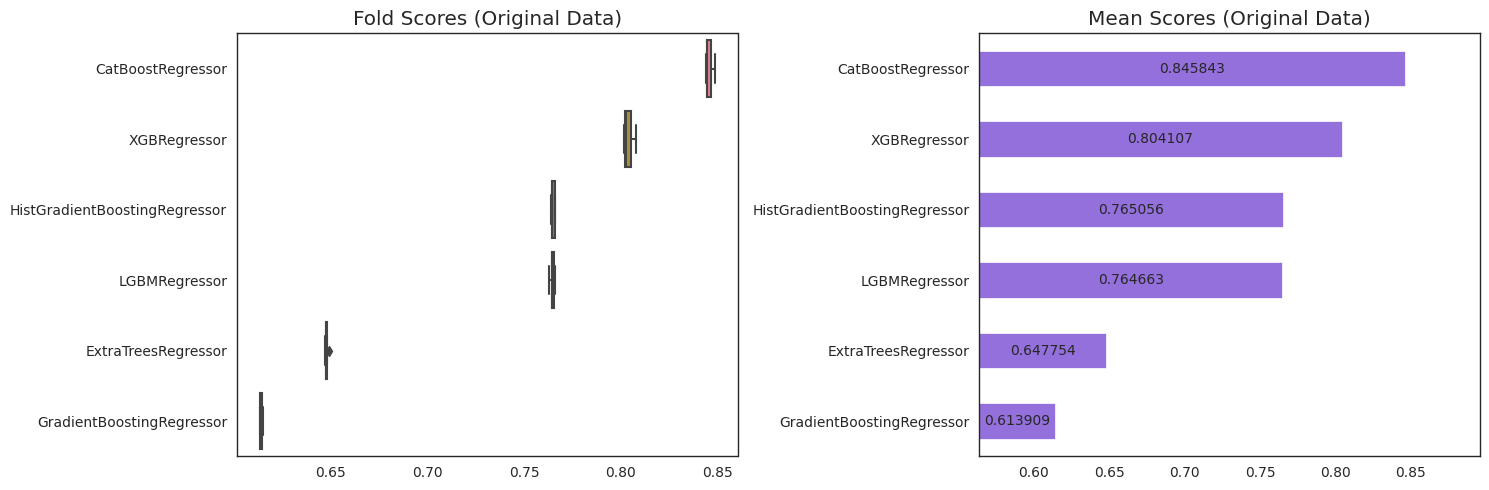

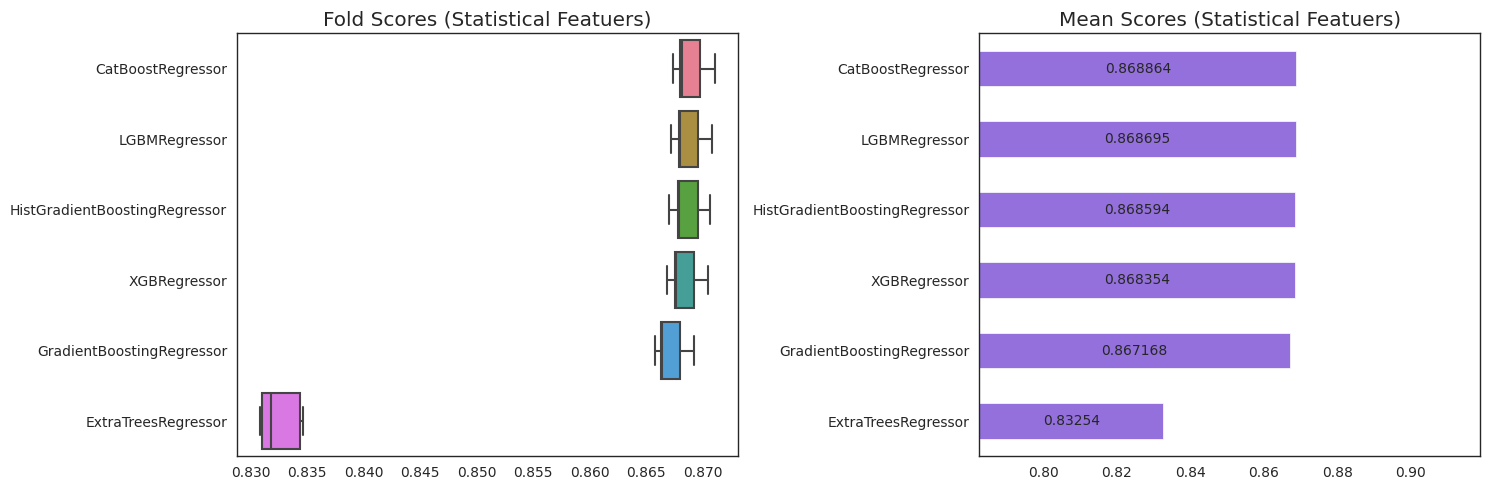

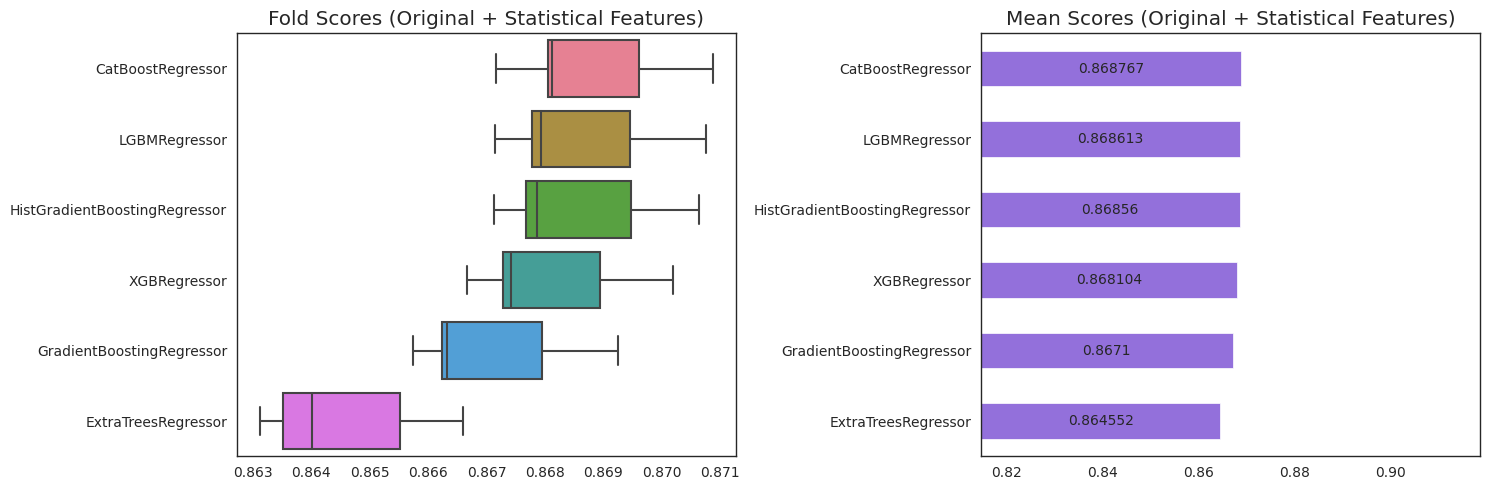

In [16]:
model_scores_df_0 = pd.DataFrame(model_scores_0)
model_scores_df_1 = pd.DataFrame(model_scores_1)
model_scores_df_2 = pd.DataFrame(model_scores_2)

plot_scores(model_scores_df_0, 'Original Data')
plot_scores(model_scores_df_1, 'Statistical Featuers')
plot_scores(model_scores_df_2, 'Original + Statistical Features')

In [17]:
def plot_all_cdfs(model_preds, y, title):
    sns.set_style("white")
    fig, axs = plt.subplots(2, 3, figsize=[15, 10])

    axs = axs.flatten()
    i = 0
    for ax, (model, preds) in zip(axs, model_preds.items()):
        sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target', ax=ax, color='#9370DB')
        sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model, ax=ax, color=sns.color_palette("husl")[i % len(sns.color_palette("husl"))])
        ax.set_title(model, fontsize=15)
        ax.set_xlabel('Flood Probability', fontsize=10)
        ax.set_ylabel('Proportion', fontsize=10)
        ax.legend()
        i += 1
    fig.suptitle(f'Cumulative Distribution Functions ({title})', fontsize=20)

    plt.tight_layout()
    plt.show()

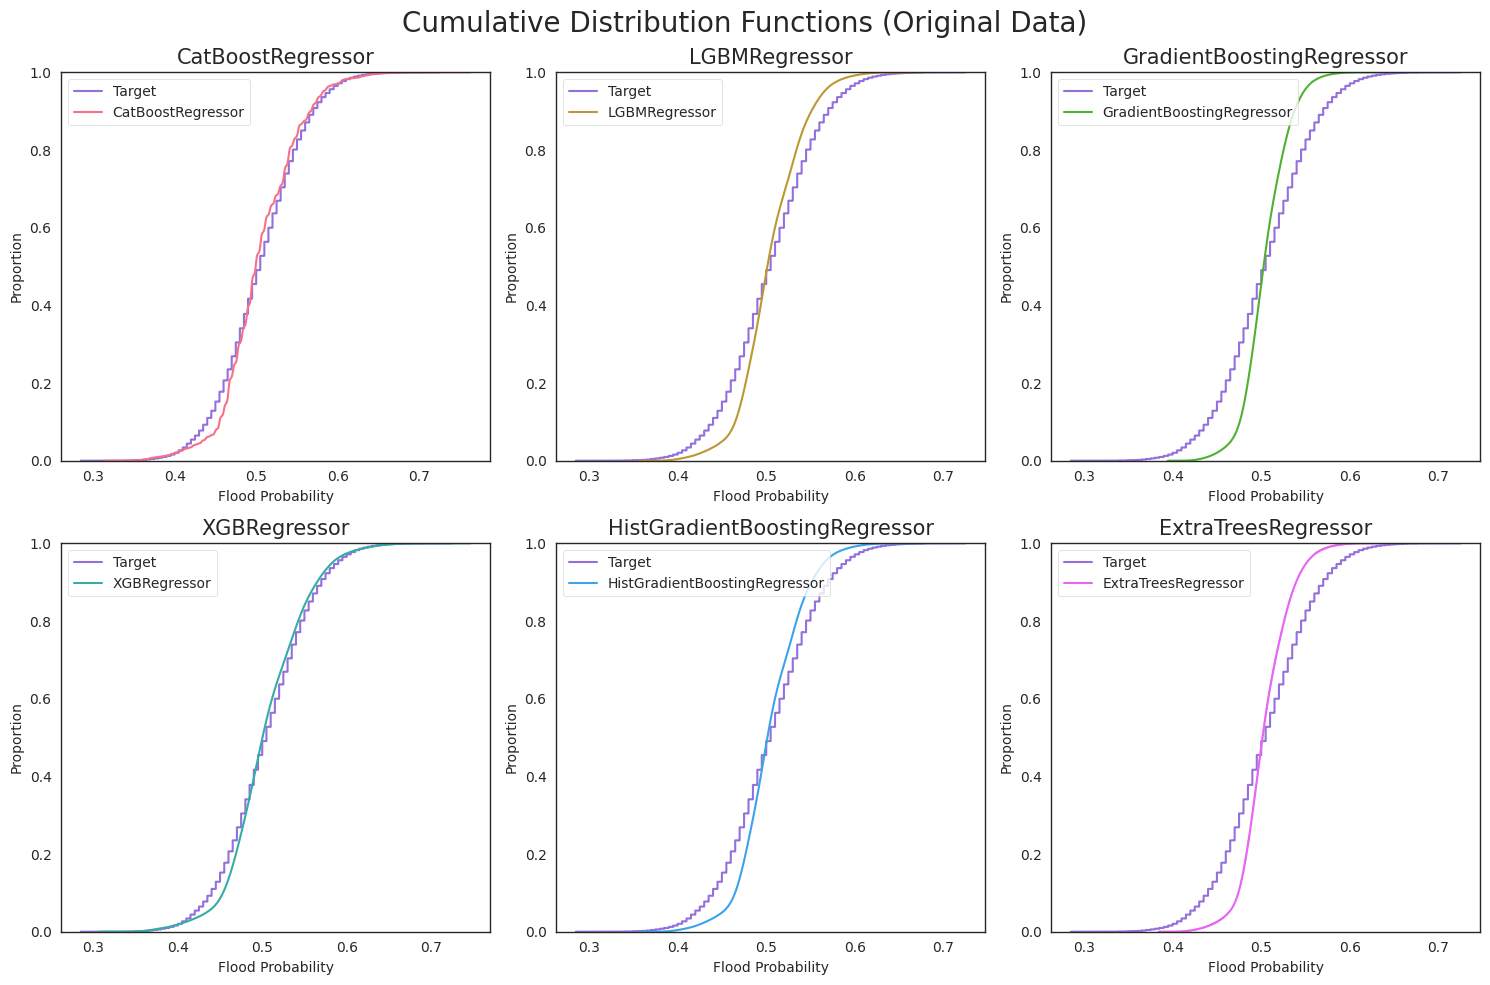

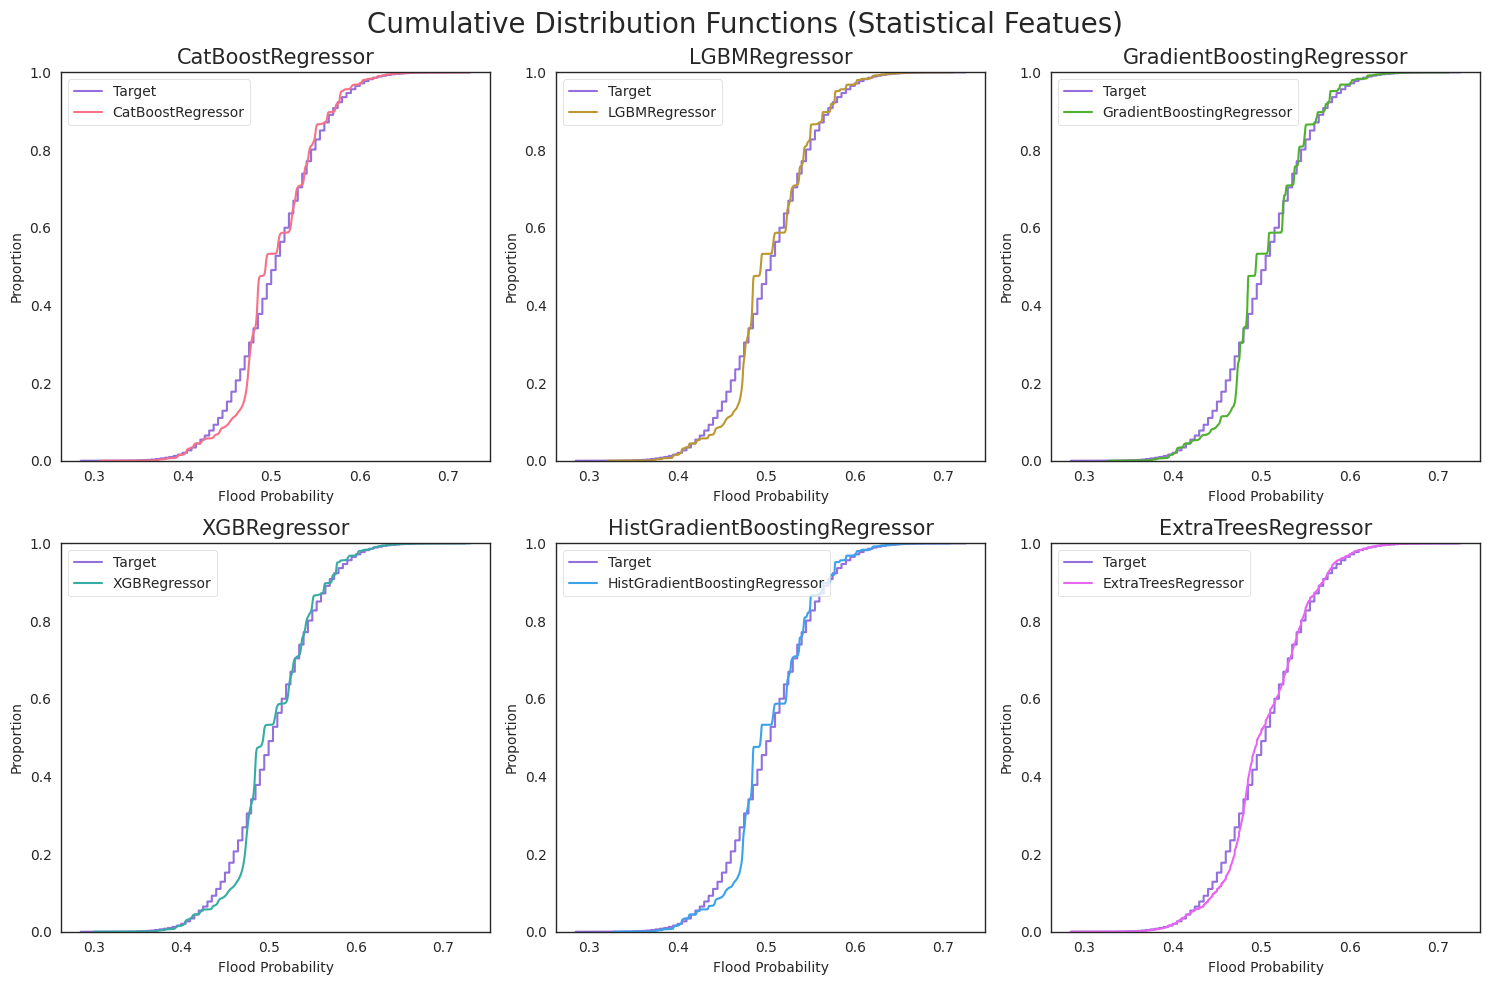

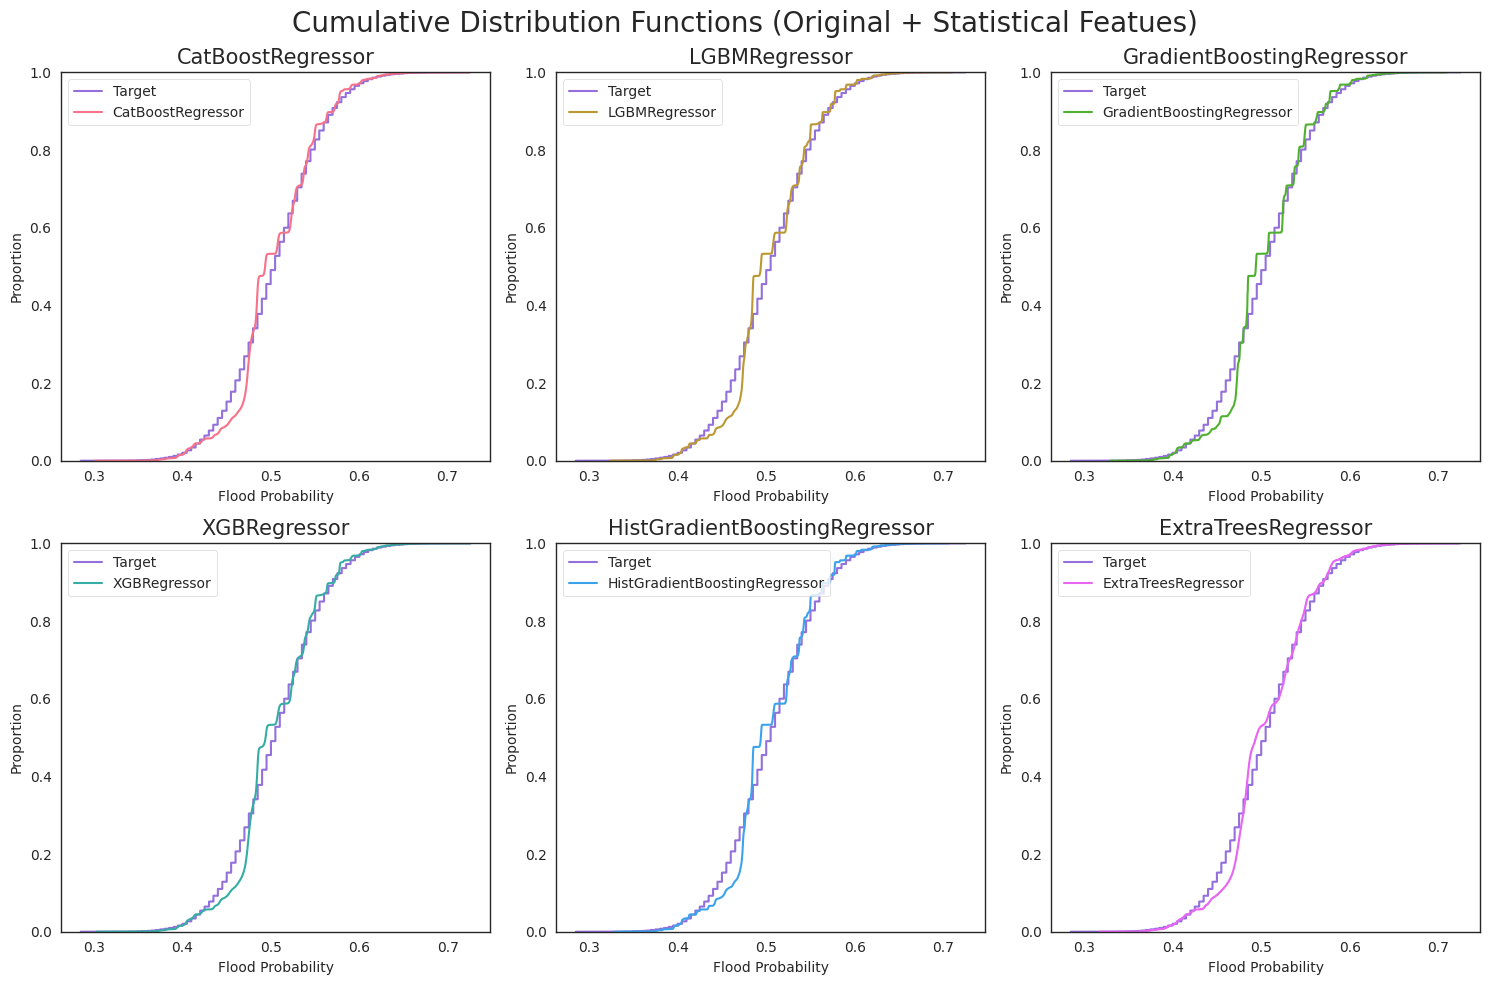

In [18]:
plot_all_cdfs(model_preds_0, y_0, 'Original Data')
plot_all_cdfs(model_preds_1, y_1, 'Statistical Featues')
plot_all_cdfs(model_preds_2, y_2, 'Original + Statistical Featues')

# Retraining the Best Model and Creating a Submission File

In [19]:
test = add_stat_features(test, feature_cols, unique_vals)

best_model = CatBoostRegressor(random_state=SEED, verbose=False)
best_model.fit(X_1, y_1)
test_preds = best_model.predict(test)

submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577222
1,1117958,0.454882
2,1117959,0.450017
3,1117960,0.468664
4,1117961,0.467403
